In [1]:
import sys
import os

import matplotlib.pyplot as plt
from pylab import title, figure, xlabel, ylabel, xticks, bar, legend, axis, savefig
from matplotlib.font_manager import FontProperties
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
from scipy.optimize import least_squares,curve_fit

import math
import configparser
from configparser import ConfigParser 

from tqdm.autonotebook import tqdm

import datetime 
from datetime import timedelta



C:\Users\49151\anaconda3\lib\site-packages\ipykernel_launcher.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def quad_experiment(KD,c_max=10,n_c=6):
    '''
    creates a list of concentrations which quadratically rising between 
    the concentration c_start and c_max and zero.
    Inputs:
        KD, dissociation constant as float
        c_max highest ligand concentration in multiples of KD as float
        n_c: number of different concentrations as int
    Return:
        set of concentrations as numpy array
    '''
    c_start = c_max / 2**(n_c-2)
    c_single_list = [c_start * 2**i * KD for i in range(n_c-1)]
    return np.concatenate([[0],c_single_list])
    
def alpha_to_c(KD,alpha):
    '''
    recalculation of c from alpha with given KD
    Input:
        KD: dissociation constant as float
        alpha: complexed fraction as float betwenn 0 and 1
    
    Return:
        c as float
    '''
    return KD*alpha/(1-alpha)


def inv_lin_experiment(KD,c_max,n_c=6,alpha_low=0):
    '''
    creates a list of concentrations which are linearly equal spaced on the alpha scale
    Inputs:
        KD: dissociation constant as float
        c_max: highest ligand concentration in multiples of KD as float
        n_c: number of different concentrations as int
        alpha_low: start point of concentration range in alpha as float between 0 and 1
    Return:
        set of concentrations as list
    '''
    c_max_c = c_max * KD
    alpha_max= c_max_c /(KD+c_max_c)
    alpha_list = np.linspace(alpha_low,alpha_max,n_c)
    c_single_list = [alpha_to_c(KD,x) for x in alpha_list]

    return c_single_list

def C_set(KD,c_max,resolution=20,include_zero = True,log_c_min=-1):
    
    """
    This function defines the set of concentration values
    Inputs:
        KD: dissociation constant as float
        c_max: highest ligand concentration in multiples of KD as float
        log_c_min: log10 start value of the set
        Resolution: number of values per log unit
    Return:
        Numpy array of the C_set
    """
    log_c_max = np.log10(c_max*KD)
    c_range = int((log_c_max - log_c_min ) *resolution +1)
    c_set = np.array(np.logspace(log_c_min,log_c_max,c_range))
    if include_zero:
        c_set = np.concatenate([[0],c_set])
    
    return c_set



def ms_ACE_no_eta(c,KD,uc,uf):
    '''
    Implementation of the ms-ACE model function
    without viscosity correction based on KA
    inputs:
        c: ligand concentration as float
        KD: dissociation constant as float c and KD must be expressed in
                the same unit e.g. mol/l
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
    return:
        ui:mobility at concentration = c as float
    '''
    KA = 1/KD
    u_i = (uf + KA * uc *c)/(1+KA*c)
    
    return u_i


def variance_function_ms_ACE(c,beta0,beta1):
    '''
    Calculation of the mobility variance as a function of c.
    Inputs:
        c: concentration  as float
        beta0,beta1: empirical parameter  as floats
    return:
       prediced variance as float
    '''
    
    predicted_var = beta0 *np.exp(beta1 * c)
    
    return predicted_var


def duf(c,uf,uc,KD):
    '''
    Calculates the first derivative of the ACE function
    with respect to uf.
    inputs:
        c: ligand concentration as float
        KD: dissociation constant as float c and KD must be expressed in
                the same unit e.g. mol/l
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
    return:
        first derivative with respect to uf as float
    '''
    return KD/(c+KD)

def duc(c,uf,uc,KD):
    '''
    Calculates the first derivative of the ACE function
    with respect to uc.
    inputs:
        c: ligand concentration as float
        KD: dissociation constant as float c and KD must be expressed in
                the same unit e.g. mol/l
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
    return:
        first derivative with respect to uc as float
    '''
    return c/(c+KD)

def dKD(c,uf,uc,KD):
    '''
    Calculates the first derivative of the ACE function
    with respect to KD.
    inputs:
        c: ligand concentration as float
        KD: dissociation constant as float c and KD must be expressed in
                the same unit e.g. mol/l
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
    return:
        first derivative with respect to KD as float
    '''
    return ((uf-uc)*KD)/ (c+KD)**2


def Information_matrix_single (c,uf,uc,KD):
    """
    calculation of the Fisher information matrix
    Input:
        global: global_derivitive_functions: duf,duc,dKD
        c: ligand concentration as float
        KD: dissociation constant as float c and KD must be expressed in
                the same unit e.g. mol/l
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
    return:
        I: Fisher information matrix of a single value
    """
    global_derivitive_functions = [duf,duc,dKD]
    A = np.mat([global_derivitive_functions[i](c,uf,uc,KD) for i in range(3)])
    A_T = A.getT()
    I = np.matmul(A_T,A)

    return I


def Information_matrix_set(c_list,uf,uc,KD):
    """
    Calculation of the total fisher information matrix 
    Input:
        global: global_derivitive_functions: duf,duc,dKD
        c_list: list of ligand concentration
        KD: dissociation constant as float c and KD must be expressed in
                the same unit e.g. mol/l
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
    return:
        [0] I/I_var: fisher information matrix of all values
        [1] M: fisher information matrix of all values normalized by n
    """
    n = len(c_list)
    I = np.zeros((3,3))
    for c_value in c_list:
        I += Information_matrix_single (c_value,uf,uc,KD)
    M = I/n

    return I,M

def optimality(M, optimality_parameter = 'D'):
    
    '''
    Calculation of optimality parameter value
    Input:
        M: Fisher Inforamtion Matrix or
        average per observation information matrix
        optimality_parameter: 'D', 'E' or 'A' as str
            defines the type of computes optimality measure
            D: D-optimal determinate of inverse M, expressed as log
            E: E-optimal maximal Eigenvalue of inverse M
            A: A-optimal trace of inverse M
    Return:
        optimality parameter value
    '''
    M_inv = np.linalg.pinv(M, rcond=1e-15, hermitian=False)
    if optimality_parameter == 'D':
         opt = np.log(np.linalg.det(M_inv))     
    elif optimality_parameter == 'A':
        opt = np.trace(M_inv)
    elif optimality_parameter == 'E':
        E = np.linalg.eigvals(M_inv)
        opt = np.amax(E)
        
    return opt

def delta_opt_minus(c_list_df,c_rest_df,uf,uc,KD,opt_mode,k_factor=3):
    '''
    Step 01 of the k-fold algorithm for the
    definition of optimal concentration sets.
    
    The algorithm takes an initial set of c
    values and defines its optimality. Subsequently 
    every entry of this set is replaced by 
    every member of an alternative set. This set results 
    from a random selection from the rest of
    all possible values. The size of this selection is
    defined by the k-factor. The optimality
    is calculated for every new set and the one with the
    best optimality is defined as new concentration
    set. The excluded c is added to the rest set.
    Inputs:
        c_list_df: present concentration set as pandas DataFrame
        c_rest_df: rest concentration set,
        all possible values - c_list_df as pandas DataFrame
        KD: dissociation constant as float
            c and KD must be expressed in 
            the same unit e.g. mol/l
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
        opt_mode: optimality_parameter as 'D', 'E' or 'A' 
        k_factor: defines the split of the rest concentration set    
    return: 
        [0] new_c_list_df: new concentration set as pandas DataFrame
        [1] new_c_rest: new rest concentration set as pandas DataFrame
        [2] opt_new: optimality measure of the new_c_list_df as float
        [3] opt_begin: optimality measure of the c_list_df as float
        [4] c_out: excluded c value as float
        [5] c_in: excluded c value as float
        [6] Delta_max: Differenz of the optimality
        [7] measures from opt_new vs. new_c_list_df as float
    '''
    Delta_list = {'c_out':[],'c_in':[],'index_out':[],'index_in':[],'opt':[],'Delta':[]}
    K_sample_size = int(len(c_rest_df)/k_factor)
    C_rest_K = c_rest_df.sample(K_sample_size)
    M = Information_matrix_set(c_list_df['c'],uf,uc,KD)[1]
    opt_begin =  optimality(M, optimality_parameter = opt_mode)
    
    for i in range(len(c_list_df)):
            index_out = c_list_df.index[i]
            reduced_c_list = c_list_df.drop(index_out)
            c_out = c_list_df['c'][index_out]
            for j in range(len(C_rest_K)):
                index_in = C_rest_K.index[j]
                c_in_df = C_rest_K.filter(items=[index_in],axis=0)
                stocked_list = pd.concat([reduced_c_list, c_in_df], ignore_index=False)
                c_in = c_in_df['c'][index_in]
                Delta_list['c_out'].append(c_out)
                Delta_list['index_out'].append(index_out)
                Delta_list['c_in'].append(c_in)
                Delta_list['index_in'].append(index_in)
                M_ij = Information_matrix_set(stocked_list['c'],uf,uc,KD)[1]
                opt_ij = optimality(M_ij, optimality_parameter = opt_mode)
                Delta_opt =  opt_ij - opt_begin 
                Delta_list['opt'].append(opt_ij)
                Delta_list['Delta'].append(Delta_opt)
            
    Delta_list_df = pd.DataFrame(Delta_list)
    index_delta_opt_min = Delta_list_df['opt'].argmin()
    index_min_out =  Delta_list_df['index_out'][index_delta_opt_min]
    index_min_in =  Delta_list_df['index_in'][index_delta_opt_min]
    c_out = c_list_df['c'][index_min_out]
    c_out_df = c_list_df.filter(items=[index_min_out],axis=0)
    c_in = C_rest_K['c'][index_min_in]
    c_best_red = c_list_df.drop(index_min_out) 
    c_in_df = C_rest_K.filter(items=[index_min_in],axis=0)
    new_c_list_df = pd.concat([c_best_red, c_in_df], ignore_index=False)
    new_c_rest_red = c_rest_df.drop(index_min_in)
    new_c_rest = pd.concat([new_c_rest_red, c_out_df], ignore_index=False)
    opt_new =   Delta_list_df['opt'][index_delta_opt_min]
    Delta_max = Delta_list_df['Delta'][index_delta_opt_min]
    
    return new_c_list_df, new_c_rest, opt_new,opt_begin, c_out, c_in, Delta_max

def opt_loop(c_total_in_df,uf,uc,KD,k_factor,opt_mode,no_c,change_threshold=0,multiply=None):
    '''
    Step 02 of the k-fold algorithm for the definition of optimal
    concentration sets.Repeats step 01 until the 
    change of optimality reaches a  defined threshold.
    Inputs:
        c_total_in_df: all possible candidates of the
            concentration set as pandas DataFrame
        KD: dissociation constant as float
                c and KD must be expressed 
                in the same unit e.g. mol/l
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
        opt_mode: optimality_parameter as 'D', 'E' or 'A' 
        k_factor: defines the split of the rest concentration set
        no_c: number of entries in the
            desired concentration set as int
        change_threshold: stops the iteration
            if the change in optimality is not smaller
            than the threshold as float
        multiply: Defines the maximal number
            of repeated values within the set as int 
    return: 
        track_df: DataFrame with all important measures 
        of the iteration as pandas DataFrame 
            within the DataFrame: 
                iteration: counter of iterations as int
                c_set: current concentration set as list
                opt_value: optimality measure of 
                    thec_set as float
                c_out: excluded c value as float
                c_in: excluded c value as float
                Delta_opt: Differenz of the optimality
                    measures from c_set vs. previous set as float 
    '''
    track_dict = {'iteration':[0], 'c_set':[],'opt_value':[np.nan],'c_in':[np.nan],'c_out':[np.nan],'Delta_opt':[-100]}
    if multiply:
        c_total_in_df =  pd.concat([c_total_in_df for __ in range(multiply)],ignore_index=True)
    iteration_counter = 0
    c_list_df = c_total_in_df.sample(no_c)
    indi_c_list_df = list(c_list_df.index)
    c_rest_df = c_total_in_df.drop(indi_c_list_df)
    track_dict['c_set'].append(c_list_df['c'])
    new_c_list_df, new_c_rest, opt_new,opt_begin, c_out, c_in, Delta_max = delta_opt_minus(c_list_df,c_rest_df,uf,uc,KD,opt_mode,k_factor=3)
    while Delta_max < change_threshold:
        iteration_counter +=1
        track_dict['c_set'].append(new_c_list_df)
        track_dict['iteration'].append(iteration_counter)
        track_dict['Delta_opt'].append(Delta_max)
        track_dict['c_in'].append(c_in)
        track_dict['c_out'].append(c_out)
        track_dict['opt_value'].append(opt_new)
        c_list_df = new_c_list_df
        c_rest_df = new_c_rest
        new_c_list_df, new_c_rest, opt_new,opt_begin, c_out, c_in, Delta_max = delta_opt_minus(c_list_df,c_rest_df,uf,uc,KD,opt_mode,k_factor=3)
    iteration_counter +=1
    track_df = pd.DataFrame(track_dict)
    
    return track_df

def rep_opt(c_total_in_df,uf,uc,KD,k_factor,opt_mode,no_c,change_threshold=0,repeats=10,multiply=None):
    '''
    Step 02 of the k-fold algorithm for the definition of optimal
    concentration sets.Repeats step 01 until the 
    change of optimality reaches a  defined threshold.
    Inputs:
        see step 02
        repeats: number of random starts
    return: 
        [0]: c_opt: The optimal concentration set pandas DataFrame
        [1]: see step 02
    '''
    
    total_df = pd.concat([opt_loop(c_total_in_df,uf,uc,KD,k_factor,opt_mode,no_c,change_threshold,multiply) for __ in range(repeats)],ignore_index=True)
    
    
    opt_index = total_df['opt_value'].argmin()
    
    c_opt = total_df['c_set'][opt_index]
    
    return c_opt, total_df

def asym_percentile(data,p_value):
    '''
    Calculation of the asymetric interquantile ranges
    This code was developed in cooperation with 
    Thomas Martin Dutschmann
    inputs: 
        data: data array as list
        p_value: definition of the percentile
    return:
        x_low: begin of the percentile as float 
        x_high: end of the percentile as float 
        p_low: begin relative rank as float  {0:1}
        p_high: end relative rank as float  {0:1}
        x_delta: range between x_low and x_high as float
        x_mean: mean of data as float
        x_median: median of data as float
        x_05: central value of data as float
        x_variance: variance of data as float
        x_SD: standard deviation of data as float
    Ref:
        'Evaluation of measurement dataSupplement 1 to the Guide to the expression of
        uncertainty in measurement Propagation of distributions using a Monte Carlo method'
    '''
    x_values = np.sort(data)
    perc = np.arange(1,len(data)+1)/len(data)
    Dict_Fit = dict(zip(perc, x_values))
    Dict_x = dict(zip(x_values,perc))
    Delta=[]
    p=p_value
    p_dict = int(p*len(Dict_Fit))
    keys = list(Dict_Fit.keys())
    for i in range(len(Dict_Fit)-p_dict):
        Delta.append(Dict_Fit[keys[i+p_dict]]-Dict_Fit[keys[i]])
    low = Delta.index(np.amin(Delta))
    high = low + p_dict
    x_low = x_values[low]
    x_high = x_values[high]
    p_low = perc[low]
    p_high = perc[high]
    x_delta = x_high - x_low
    x_mean = np.mean(x_values)
    x_median = np.median(x_values)
    x_variance = np.var(x_values)
    x_SD = np.sqrt(x_variance)
    if len(x_values) % 2 == 0:
        x_05 = (x_values[int(len(x_values)/2 -1)] + x_values[int(len(x_values)/2 )])/2
    else:
        x_05 = x_values[int(len(x_values)/2 -0.5)] 
            
    return x_low, x_high, p_low, p_high,x_delta, x_mean, x_median, x_05,x_variance,x_SD

def ECDF_full_data(Fit,p_value):
    '''
    Calculation of the asymetric interquantile ranges
    This code was developed in cooperation with 
    Thomas Martin Dutschmann
    inputs: 
        Fit: data array as list
        p_value: definition of the percentile
    return:
        x_low: begin of the percentile as float 
        x_high: end of the percentile as float 
        inter_quantile_range: range between x_low and x_high as float
        x_mean: mean of data as float
        x_median: median of data as float
        x_variance: variance of data as float
        x_SD: standard deviation of data as float
        x_rel_AIQR: normalized (to mean) interquantile range as float
    Ref:
        'Evaluation of measurement dataSupplement 1 to the Guide to the expression of
        uncertainty in measurement Propagation of distributions using a Monte Carlo method'
    '''
    p=p_value
    X = ecdf_self(Fit)[0]
    Y = ecdf_self(Fit)[1]
    asym_data = asym_percentile(Fit,p)
    p_low_Fit_1 = asym_data[2]
    p_high_Fit_1 = asym_data[3]
    x_low_Fit_1 = asym_data[0]
    x_high_Fit_1 = asym_data[1]
    x_mean =  asym_data[5]
    x_median =  asym_data[6]
    x_mode =  asym_data[7]
    inter_quantile_range =  asym_data[4]
    x_mode =  asym_data[5]
    x_min = np.amin(ecdf_self(Fit)[0])
    x_max = np.amax(ecdf_self(Fit)[0])
    y_min = np.amin(ecdf_self(Fit)[1])
    y_max = np.amax(ecdf_self(Fit)[1])
    x_variance =  asym_data[8]
    x_SD = asym_data[9]
    x_CV = x_SD/x_mean
    x_rel_AIQR = inter_quantile_range/x_mean
    
    return inter_quantile_range, x_mean, x_median, x_variance, x_SD, x_CV, x_rel_AIQR


def ecdf_self(list_of_data):
    '''
    Empirical cumulative density function
    Inputs:
        list_of_data: data array
    Return:
        [0] x_values: sorted values of the input
        [1] perc: percentage of the values
    '''
    x_values = np.sort(list_of_data)
    perc = np.arange(1,len(list_of_data)+1)/len(list_of_data)
    
    return x_values, perc

def add_zeros(index_begin,max_str_length):
    '''
    Helper function for file names
    '''
    index_begin_name = str(index_begin)
    add_zeros = max_str_length - len(str(index_begin))
    for i in range(add_zeros):
        index_begin_name = '0'+index_begin_name
    return index_begin_name

def create_c_in_adv(c_type,uf,uc,KD,c_min,c_max,no_c,rep,zero_min = -1,resolution=20):
    '''
    Definition of the concentration set
    Sensitivity version
    inputs:
        c_type: defines the type of concentration set 
        KD: dissociation constant as float
        uf: mobility at concentration = 0 as float
        uc: mobility at concentration = infinity as float
        c_min: minimal concentration as pos. float
        c_max: maximal concentration as multiples of KD as pos. float
        no_c: number of different cocentrations as int
        rep: number of replicated concentrations as int
        zero_min: default minimum if the real c_min is 0
        Resolution: number of values per log unit
    not every input applies to every c_type 
    return:
        concentration set as numpy array
    '''
    if c_type == 'Log_Lin':
        c_set = create_c_in(KD,c_min,c_max,no_c,rep,zero_min = -1)
    elif c_type == 'QUAD':
        c_set = quad_experiment(KD,c_max,n_c=no_c)
    elif c_type == 'INV_Lin': 
        c_set = np.array(inv_lin_experiment(KD,c_max,n_c=no_c,alpha_low=0))
    elif c_type == 'D' or c_type == 'A' or c_type == 'E':
        C_total_set = C_set(KD,c_max,resolution=20,include_zero = True,log_c_min=-1)
        c_total_in_df = pd.DataFrame({'c':C_total_set})
        multiply_in =math.ceil(no_c/3) 
        Opt_df = rep_opt(c_total_in_df,uf,uc,KD,3,c_type,no_c,change_threshold=0,repeats=6,multiply=multiply_in)[0]
        c_set = np.array(Opt_df['c'])
    elif c_type == 'total':
         c_set = C_set(KD,c_max,resolution,include_zero = True,log_c_min=zero_min)
    elif c_type == 'sens':
        cmax_log = np.log10(c_max*KD)
        if c_max <= 1:
            c_check_list = [[-4,-3,2],[-3,-2,4],[-2,-1,8],[-1,cmax_log,16]]
        else:
            c_check_list = [[-4,-3,2],[-3,-2,4],[-2,-1,8],[-1,0,16],[0,cmax_log,resolution]]  
        c_set_KD = np.unique(np.concatenate([[0],np.concatenate([np.logspace(c_check_list[i][0],c_check_list[i][1],c_check_list[i][2]) for i in range(len(c_check_list))])]))
        c_set = [KD* x for x in c_set_KD]
    return c_set

In [3]:

# DOE full factorial DS,PS ms-ACE
KD_list = [1]
uc_list = [10]
uf_list = [1]
c_min_list = [0]
c_max_list = [10]
no_c_list = [8]
rep_list = [1]
MU_type_list = ['abs']
MU_specs_no_list = [0]
MU_specs_abs = [0.1]
MU_specs_rel = [[0.00592,0.012],[0.00592,0.014],[0.00592,0.016]]
c_type_list = ['Log_Lin','QUAD','INV_Lin','D','E','A']

DS_PS_dict = {'KD':[],'uc':[],'uf':[],'c_min':[],'c_max':[],'no_c':[],'rep':[],'MU_type':[],'MU_specs':[]}
key_list = list(DS_PS_dict.keys())

for c_max in c_max_list:
    for c_min in c_min_list:
        if not c_min < c_max:
            break
        for KD in KD_list:
            for uc in uc_list:
                for uf in uf_list:
                    for no_c in no_c_list:
                        for rep in rep_list:
                            for MU_type in MU_type_list:
                                for MU_no in MU_specs_no_list:
                                    if MU_type == 'abs':
                                        MU_spec = MU_specs_abs[MU_no]
                                    else:
                                        MU_spec = MU_specs_rel[MU_no]
                                        
                                    list_of_parameter = [KD,uc,uf,c_min,c_max,no_c,rep,MU_type,MU_spec]
                                    for i in range(len(list_of_parameter)):
                                        name = key_list[i]
                                        parameter = list_of_parameter[i]
                                        DS_PS_dict[name].append(parameter)
                                                              
DS_PS_DF = pd.DataFrame(DS_PS_dict)

for key in DS_PS_DF.select_dtypes('number').keys():
    
    data_array = DS_PS_DF[key]
    min_value = data_array.min()
    max_value = data_array.max()
    range_value = max_value - min_value

    new_name = key + '_norm'
    norm = [(data_array[i] - min_value)/range_value for i in range(len(data_array))]
    DS_PS_DF[new_name] = norm

abs_value_min = np.min(MU_specs_abs)
abs_value_max = np.max(MU_specs_abs)
abs_range = abs_value_max - abs_value_min
rel_1_list = [MU_specs_rel[j][0] for j in range(len(MU_specs_rel))]
rel_1_list = np.unique(rel_1_list)
rel_2_list = [MU_specs_rel[j][1] for j in range(len(MU_specs_rel))]
rel_2_list = np.unique(rel_2_list)
rel1_value_min = np.min(rel_1_list)
rel1_value_max = np.max(rel_1_list)
rel1_range = rel1_value_max - rel1_value_min
rel2_value_min = np.min(rel_2_list)
rel2_value_max = np.max(rel_2_list)
rel2_range = rel2_value_max - rel2_value_min
MU_type_norm = []
MU_spec_norm = []
for i in range(len(DS_PS_DF)):
    MU_type = DS_PS_DF['MU_type'][i]
    MU_specs = DS_PS_DF['MU_specs'][i]
    if MU_type == 'abs':    
        MU_type_norm.append(1)
        if len(MU_specs_abs) > 1:
            MU_spec_norm.append((MU_specs - abs_value_min) / abs_range)
        else:
            MU_spec_norm.append(1)
    else:
        MU_type_norm.append(2)
        if len(rel_1_list) > 1:
            rel_norm_1 = (MU_specs[0] - rel1_value_min) / rel1_range
        else:
            rel_norm_1 = 1
        if len(rel_2_list) > 1:
            rel_norm_2 = (MU_specs[1] - rel2_value_min) / rel2_range
        else:
            rel_norm_2 = 1
        MU_spec_norm.append([rel_norm_1,rel_norm_2])
DS_PS_DF['MU_type_norm'] = MU_type_norm
DS_PS_DF['MU_specs_norm'] = MU_spec_norm

C:\Users\49151\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\49151\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


In [4]:

sens_KD = 1
sens_c_max = 1
config = configparser.ConfigParser()

#Parameter_file = sys.argv[1]
#config.read(Parameter_file)
#if Parameter_file == '-f':
Parameter_file = 'ms_ACE_MC_SIM_c_dist.ini'
config.read(Parameter_file)

index_begin = int(config['Index']['start'])
index_begin = 0
index_end = len(DS_PS_DF)
no_runs = int(config['runs']['runs'])
exclude = int(config['exclude']['exclude'])
exclude_abs = int(config['exclude']['exclude_abs'])
excl_low = 1/exclude 
p_value = float(config['p_value']['p_value'])
random_index_on = bool(int(config['Index']['random']))
random_no = int(config['Index']['random_no'])
if index_end >= len(DS_PS_DF):
    index_end = len(DS_PS_DF)
max_str_length = len(str(len(DS_PS_DF)))
index_begin_name = add_zeros(index_begin,max_str_length)
index_end_name = add_zeros(index_end,max_str_length)
Index_list =  range(index_begin,index_end+1)
now = datetime.datetime.now()
timestamp = str(now)[0:4] + str(now)[5:7] + str(now)[8:10] 
complete_index_list_reprod_shuffle = np.arange(len(DS_PS_DF))
rdm_suffle_seed = 12151989
np.random.seed(rdm_suffle_seed)
np.random.shuffle(complete_index_list_reprod_shuffle)
Index_list = complete_index_list_reprod_shuffle[index_begin:index_end+1]
if random_index_on:
    Index_list =np.random.choice(complete_index_list_reprod_shuffle,size=random_no, replace=False)
    Index_list =np.random.choice(complete_index_list_reprod_shuffle,size=None, replace=False)
    index_begin_name ='rdm'
    index_end_name ='rdm'
if Index_list.ndim == 0:
    Index_list = [Index_list]
outname = f'ms_ACE_MC_SIM_{timestamp}'

outname_valid = False
file_counter = 1
while not outname_valid:
    if f'{outname}.pkl' in os.listdir():
        outname += f'_{file_counter}'
        file_counter += 1
    else: 
        outname_valid = True
print()
print('--------------------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------------------')
print()
print('MC Simulation ')
print(f'Parameter file: {Parameter_file}')
print(f'from {index_begin} to {index_end} with {no_runs} no of runs')
print()
print(f'Filename: {outname}')
print()
print('--------------------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------------------')
out_pkl = f'{outname}_sens.pkl'
out_csv = f'{outname}_sens.csv'
MC_results_dict = {}
basic_key_list = ['Parameter no','time','duration','rel duration','Seed no','c_type', 'no runs','exclude parameter','p value','parameter file','outname']
additional_keys = ['MRR','nMRR','SD_KD','DPP','DPR','NoDP']
opt_keys = ['D opt', 'E opt', 'A opt']
result_keys = ['mean', 'Var','SD','CV', 'AIQR','rel AIQR','Trueness','rel Trueness']
result_key_a = ['KD','uc','uf']
additinal_results = ['abs fails','rel fails']
sens_dict = {'c':[],'AIQR':[],'Sens':[]}
c_type = 'sens'
for key in basic_key_list:
    MC_results_dict[key] = []                 
for key in DS_PS_DF.keys():
    MC_results_dict[key] = []
for add_key in additional_keys:
    MC_results_dict[add_key] = []
for key_a in result_key_a:
    for key_b in result_keys:
        key = key_a + ' ' + key_b
        MC_results_dict[key] = []
for add_key in additinal_results:
    MC_results_dict[add_key] = []
duration_total = datetime.timedelta()

for i in Index_list:
    now = datetime.datetime.now()
    timestamp = str(now)[0:4] + str(now)[5:7] + str(now)[8:10] + '_'+ str(now)[11:13] + '_' +  str(now)[14:16]
    i_in = np.where(Index_list==i)
    i_in = int(i_in[0])+1
    to_go = len(Index_list) - i_in
    print()
    print('-----------------------------------------------')
    print(f'number {i_in} of {len(Index_list)}')
    print()
    print(f'This is row no.: {i}')
    print(f'start time: {now}')
    print()
    parameter_import = DS_PS_DF.iloc[i]
    Seed_number = np.random.randint(10**6)
    np.random.seed(Seed_number)
    MC_results_dict['Parameter no'].append(i)
    MC_results_dict['time'].append(timestamp)
    MC_results_dict['Seed no'].append(Seed_number)
    MC_results_dict['no runs'].append(no_runs)
    MC_results_dict['exclude parameter'].append([exclude,exclude_abs])
    MC_results_dict['p value'].append(p_value)
    MC_results_dict['parameter file'].append(Parameter_file)
    MC_results_dict['outname'].append(outname)
    MC_results_dict['c_type'].append(c_type)
    parameter_list = []
    for key in parameter_import.keys():
        MC_results_dict[key].append(parameter_import[key])
    KD, uc, uf, c_min, c_max, no_c, rep, MU_type, MU_specs = parameter_import[0:9]
    print(f'KD: {KD}, uc: {uc}, uf:{uf}')
    print(f'cmin: {c_min}, cmax: {c_max}, no c: {no_c}, rep: {rep}')
    print(f'MU type: {MU_type}, MU specs:{MU_specs}')
    print()
    print()
    print('-----------------------------------------------')
    print(f'start defining c type {c_type}')
    print()
    print(f'start time: {now}')
    print()
    c_in =  create_c_in_adv('sens',__,__,sens_KD,__,sens_c_max,__,__,zero_min = -2,resolution=32)
    now_b = datetime.datetime.now()
    print(f'end defining c type {c_type}')
    print()
    print(f'end time: {now_b}')
    E_mu_eff_in_list = np.array([ms_ACE_no_eta(c,KD,uc,uf) for c in c_in] )
    if MU_type == 'abs':
        E_SD_list = [MU_specs for __ in range(len(E_mu_eff_in_list))]
        SD_KD = MU_specs
    else:
        E_SD_list = [np.sqrt(variance_function_ms_ACE(c,MU_specs[0],MU_specs[1])) for c in c_in]
        SD_KD = np.sqrt(variance_function_ms_ACE(KD,MU_specs[0],MU_specs[1]))
    NoDP = no_c * rep
    MRR = abs(uc-uf)
    nMRR = MRR/SD_KD
    c_in_min = np.min(c_in)
    alpha_min = c_in_min/(KD+c_in_min)
    c_in_max = np.max(c_in)
    alpha_max = c_in_max/(KD+c_in_max)
    DPP = np.mean([alpha_min,alpha_max])
    DPR = alpha_max - alpha_min

    additional_parameter_list = [MRR,nMRR,SD_KD,DPP,DPR,NoDP]
    for key_i in range(len(additional_keys)):
        key = additional_keys[key_i]
        add = additional_parameter_list[key_i]
        MC_results_dict[key].append(add)
    Simulation_dict = {'KD':[],'uc':[],'uf':[]}
    no_fails = 0
    for run in range(no_runs):
        mu_rdm_list = np.array([np.random.normal(mean_in,SD_in,size=None) for mean_in,SD_in in zip(E_mu_eff_in_list,E_SD_list)])
        try:
            popt, pcov = curve_fit(ms_ACE_no_eta, c_in, mu_rdm_list)
        except:
            popt =  ['f','f','f']
            no_fails += 1
        if not popt[0] == 'f':
            KD_excl = popt[0]/KD < excl_low or popt[0]/KD > exclude
            uc_excl = popt[1] < uc - exclude_abs or popt[1] > uc + exclude_abs
            uf_excl = popt[2] < uf - exclude_abs or popt[2] > uf + exclude_abs
            if KD_excl or uc_excl or uf_excl:
                popt =  ['f','f','f']
                no_fails += 1
        if not popt[0] == 'f': 
            for j in range(len(Simulation_dict.keys())):
                key = list(Simulation_dict.keys())[j]
                Simulation_dict[key].append(popt[j])
    for j in range(len(Simulation_dict.keys())):
        key = list(Simulation_dict.keys())[j]
        Data = Simulation_dict[key]
        inter_quantile_range, x_mean, x_median, x_variance, x_SD, x_CV, x_rel_AIQR = ECDF_full_data(Data,p_value)
        if key == 'KD':
            sens_dict['c'].append(np.nan)
            sens_dict['AIQR'].append(inter_quantile_range)
            Sens_denom = inter_quantile_range
            sens_dict['Sens'].append(1)
        E_BP = parameter_import[key]
        Trueness = x_mean - E_BP
        Trueness_rel ='BP: 0'
        if not E_BP == 0:
            Truness_rel = abs(Trueness)/E_BP
        summary_list = [x_mean,x_variance,x_SD, x_CV,inter_quantile_range,x_rel_AIQR,Trueness,Truness_rel]
        for q in range(len(result_keys)):
            result_key_in = result_keys[q]
            end_key = key + ' ' + result_key_in
            result = summary_list[q]
            MC_results_dict[end_key].append(result)
    MC_results_dict['abs fails'].append(no_fails)
    MC_results_dict['rel fails'].append(no_fails/no_runs)
    now2 = datetime.datetime.now()
    duration = now2 - now
    duration_total += duration
    duration_mean = duration_total/i_in
    MC_results_dict['duration'].append(duration.seconds)
    MC_results_dict['rel duration'].append(no_runs/duration.seconds)
    Average_duration = np.mean(MC_results_dict['duration'])
    Average_runs_per_sec = np.mean(MC_results_dict['rel duration'])
    now_loop = datetime.datetime.now() 
    time_to_go = to_go * duration_mean
    approximated_end = now_loop + time_to_go
    print(f'It took {duration}. Average duration: {Average_duration} seconds.')
    print(f'Runs per second: {no_runs/duration.seconds}. Average: {Average_runs_per_sec}.')
    print()
    print(f'Total time: {duration_total}, approximated end: {approximated_end}')
    print()
    print('-----------------------------------------------')
    print()
    for sens_i, sens in enumerate(E_mu_eff_in_list):
        now = datetime.datetime.now()
        timestamp = str(now)[0:4] + str(now)[5:7] + str(now)[8:10] + '_'+ str(now)[11:13] + '_' +  str(now)[14:16]
        i_in = np.where(Index_list==i)
        i_in = int(i_in[0])+1
        to_go = len(Index_list) - i_in
        print()
        print('-----------------------------------------------')
        print(f'number {i_in} of {len(Index_list)}')
        print()
        print(f'This is row no.: {i}')
        print(f'start time: {now}')
        print()
        #parameter_import = DS_PS_DF.iloc[i]
        #Seed_number = np.random.randint(10**6)
        np.random.seed(Seed_number)
        MC_results_dict['Parameter no'].append(i)
        MC_results_dict['time'].append(timestamp)
        MC_results_dict['Seed no'].append(Seed_number)
        MC_results_dict['no runs'].append(no_runs)
        MC_results_dict['exclude parameter'].append([exclude,exclude_abs])
        MC_results_dict['p value'].append(p_value)
        MC_results_dict['parameter file'].append(Parameter_file)
        MC_results_dict['outname'].append(outname)
        MC_results_dict['c_type'].append(c_type)
        parameter_list = []
        for key in parameter_import.keys():
            MC_results_dict[key].append(parameter_import[key])
        #KD, uc, uf, c_min, c_max, no_c, rep, MU_type, MU_specs = parameter_import[0:9]
        print(f'KD: {KD}, uc: {uc}, uf:{uf}')
        print(f'cmin: {c_min}, cmax: {c_max}, no c: {no_c}, rep: {rep}')
        print(f'MU type: {MU_type}, MU specs:{MU_specs}')
        print()
        print()
        print('-----------------------------------------------')
        print(f'start sen value {sens_i}')
        print()
        print(f'start time: {now}')
        print()
        #c_in =  create_c_in_adv('sens',__,__,1,__,__,__,__,zero_min = -2,resolution=20)
        now_b = datetime.datetime.now()
        print(f'end defining c type {c_type}')
        print()
        print(f'end time: {now_b}')
        #E_mu_eff_in_list = np.array([ms_ACE_no_eta(c,KD,uc,uf) for c in c_in] )
        for key_i in range(len(additional_keys)):
            key = additional_keys[key_i]
            add = additional_parameter_list[key_i]
            MC_results_dict[key].append(add)
        Simulation_dict = {'KD':[],'uc':[],'uf':[]}
        no_fails = 0
        for run in range(no_runs):
            mu_rdm_list = np.array([np.random.normal(mean_in,SD_in,size=None) for mean_in,SD_in in zip(E_mu_eff_in_list,E_SD_list)])
            exchange_pos = sens_i
            exchange_value = [sens]
            pre = mu_rdm_list[0:exchange_pos]
            post = mu_rdm_list[exchange_pos+1::]
            mu_rdm_list = np.concatenate([pre,exchange_value,post])
            try:
                popt, pcov = curve_fit(ms_ACE_no_eta, c_in, mu_rdm_list)
            except:
                popt =  ['f','f','f']
                no_fails += 1
            if not popt[0] == 'f':
                KD_excl = popt[0]/KD < excl_low or popt[0]/KD > exclude
                uc_excl = popt[1] < uc - exclude_abs or popt[1] > uc + exclude_abs
                uf_excl = popt[2] < uf - exclude_abs or popt[2] > uf + exclude_abs
                if KD_excl or uc_excl or uf_excl:
                    popt =  ['f','f','f']
                    no_fails += 1
            if not popt[0] == 'f': 
                for j in range(len(Simulation_dict.keys())):
                    key = list(Simulation_dict.keys())[j]
                    Simulation_dict[key].append(popt[j])
        for j in range(len(Simulation_dict.keys())):
            key = list(Simulation_dict.keys())[j]
            Data = Simulation_dict[key]
            inter_quantile_range, x_mean, x_median, x_variance, x_SD, x_CV, x_rel_AIQR = ECDF_full_data(Data,p_value)
            if key == 'KD':
                sens_dict['c'].append(c_in[sens_i])
                sens_dict['AIQR'].append(inter_quantile_range)
                sens_i = inter_quantile_range/Sens_denom
                sens_dict['Sens'].append(sens_i)
            E_BP = parameter_import[key]
            Trueness = x_mean - E_BP
            Trueness_rel ='BP: 0'
            if not E_BP == 0:
                Truness_rel = abs(Trueness)/E_BP
            summary_list = [x_mean,x_variance,x_SD, x_CV,inter_quantile_range,x_rel_AIQR,Trueness,Truness_rel]
            for q in range(len(result_keys)):
                result_key_in = result_keys[q]
                end_key = key + ' ' + result_key_in
                result = summary_list[q]
                MC_results_dict[end_key].append(result)
        now2 = datetime.datetime.now()
        duration = now2 - now
        duration_total += duration
        print(f'Total time: {duration_total}')
        print()
        print('-----------------------------------------------')
    MC_results_dict['abs fails'].append(no_fails)
    MC_results_dict['rel fails'].append(no_fails/no_runs)
    duration_mean = duration_total/i_in
    MC_results_dict['duration'].append(duration.seconds)
    MC_results_dict['rel duration'].append(no_runs/duration.seconds)
    Average_duration = np.mean(MC_results_dict['duration'])
    Average_runs_per_sec = np.mean(MC_results_dict['rel duration'])
    now_loop = datetime.datetime.now() 
    time_to_go = to_go * duration_mean
    approximated_end = now_loop + time_to_go
    print(f'It took {duration}. Average duration: {Average_duration} seconds.')
    print(f'Runs per second: {no_runs/duration.seconds}. Average: {Average_runs_per_sec}.')
    print()
    print(f'Total time: {duration_total}, approximated end: {approximated_end}')
    print()
    print('-----------------------------------------------')
    print()
Sens_DF = pd.DataFrame(sens_dict)
Sens_DF.to_pickle(out_pkl)
Sens_DF.to_csv(out_csv)


--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------

MC Simulation 
Parameter file: ms_ACE_MC_SIM_c_dist.ini
from 0 to 1 with 300000 no of runs

Filename: ms_ACE_MC_SIM_20220319

--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------

-----------------------------------------------
number 1 of 1

This is row no.: 0
start time: 2022-03-19 13:18:57.268131

KD: 1, uc: 10, uf:1
cmin: 0, cmax: 10, no c: 8, rep: 1
MU type: abs, MU specs:0.1


-----------------------------------------------
start defining c type sens

start time: 2022-03-19 13:18:57.268131

end defining c type sens

end time: 2022-03-19 13:18:57.270151
It took 0:02:16.760290. Average duration: 136.0 seconds.
Runs per second: 2205.88235294117

In [5]:
sens_DF = pd.DataFrame(sens_dict)

X = sens_DF['c'][1::]
Y = sens_DF['Sens'][1::]


In [6]:
sens_DF.head(2)

,c,AIQR,Sens
0,NaN,0.400564,1.000000
1,0.0,0.394927,0.985928


In [7]:

sens_DF.to_csv('Sens_data_cmax_1.csv')
sens_DF.to_pickle('Sens_data_cmax_1.pkl')

Text(0.5, 1.0, 'Sensitivity')

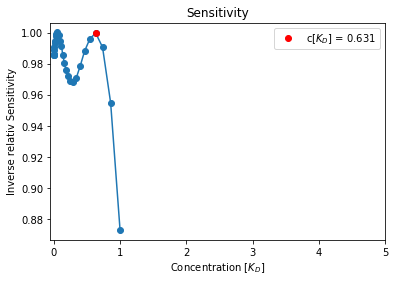

In [8]:
min_point = 25

plt.plot(X,Y,'o-')
plt.plot(X[min_point],Y[min_point],'ro',label=f'c[$K_D$] = {round(X[min_point],3)}')
#plt.xscale('log')
plt.xticks(np.linspace(0,5,6))
plt.legend()
plt.xlabel('Concentration [$K_D$]')
plt.ylabel('Inverse relativ Sensitivity')
plt.title('Sensitivity')